# 🩺 OcuSight — Explainable AI for Glaucoma Risk Prediction

This notebook demonstrates **OcuSight**, a clinical decision support prototype that predicts glaucoma risk
from wearable + clinical features (hackathon dataset: **25,000 patients**, ~**32%** positive rate).

**Pipeline**
1) Load & explore data  
2) Benchmark models (LogReg, RF, SVM, MLP, XGBoost) across Accuracy/Precision/Recall/F1/AUC  
3) Tune and finalize **XGBoost**  
4) Visualize ROC/PR and Confusion Matrix  
5) Explain predictions with **SHAP**  
6) Save deployable artifacts (model + metadata)

> Research/demo only — not a diagnostic tool.


In [84]:
# Core
import os, time, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# ML & metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
import optuna
import joblib

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Load hackathon dataset
CSV_PATH = "wearable_clinical.csv"
data = pd.read_csv(CSV_PATH)
print("Shape:", data.shape)
data.head(3)


Shape: (25000, 16)


,id,age,gender,iop,cct,heart_rate,bp_sys,screen_time_h,sleep_h,blink_per_min,pupil_mm,iop_cct_ratio,screen_sleep_ratio,age_iop,bp_screen,label
0,P00000,58.7,0,13.8,562.0,83.0,113.0,7.0,7.5,16.4,2.73,0.0246,0.2769,28.48,6.67,0
1,P00001,42.5,0,17.4,587.0,70.0,93.0,5.5,5.5,12.6,2.60,0.0296,0.3445,27.17,6.25,1
2,P00002,64.0,0,12.7,462.0,62.0,138.0,4.9,9.3,15.5,3.40,0.0276,0.1898,28.55,6.51,1


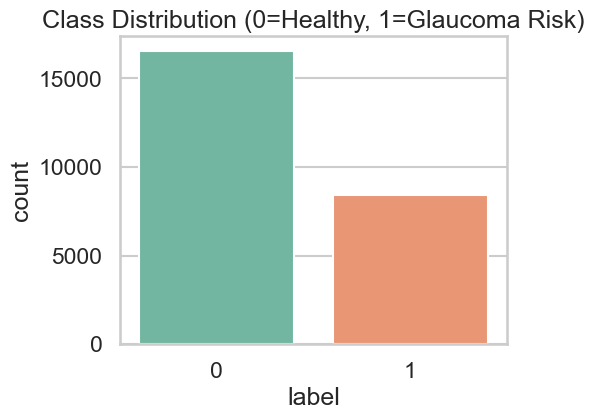

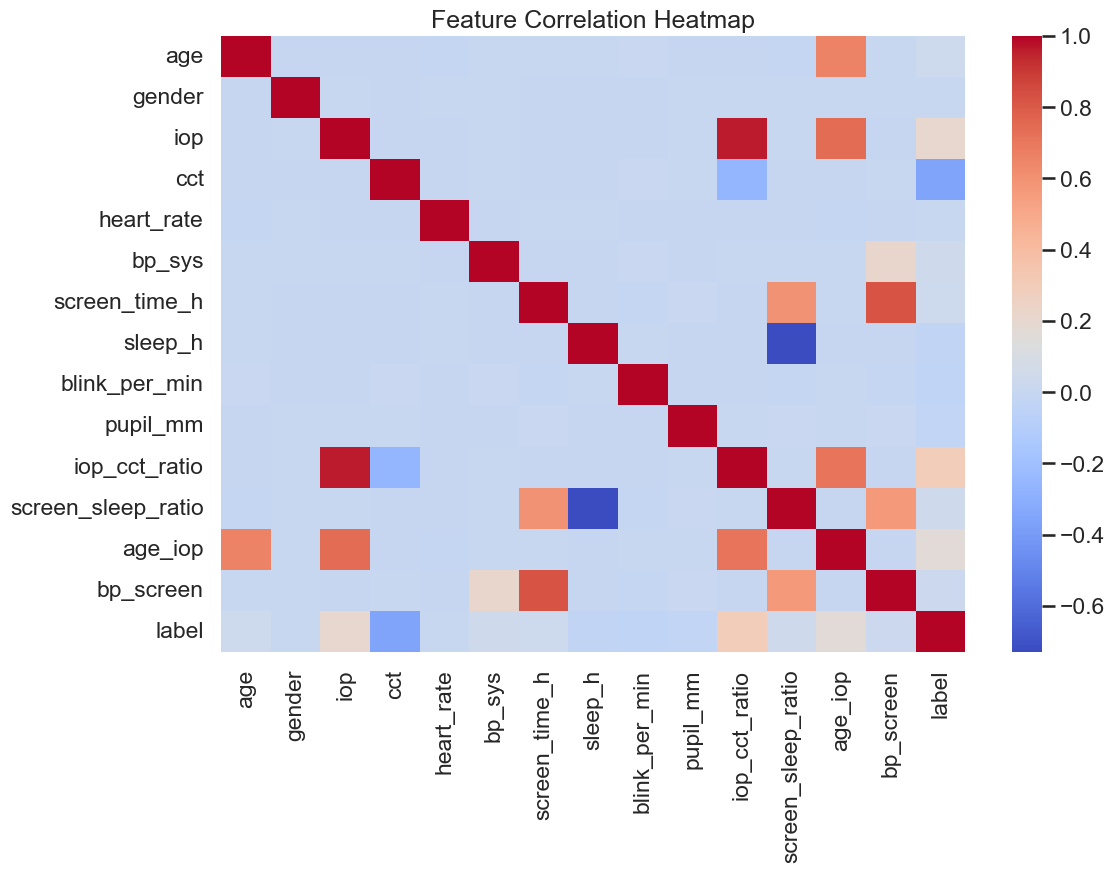

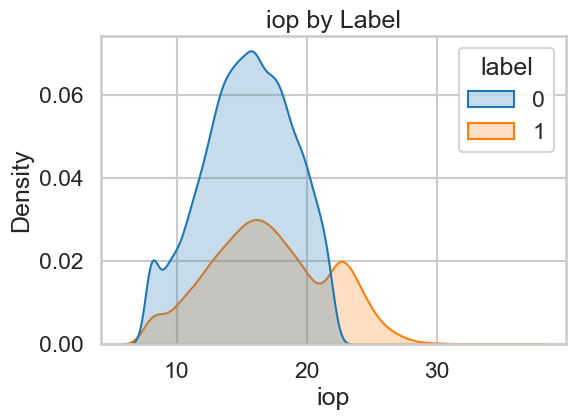

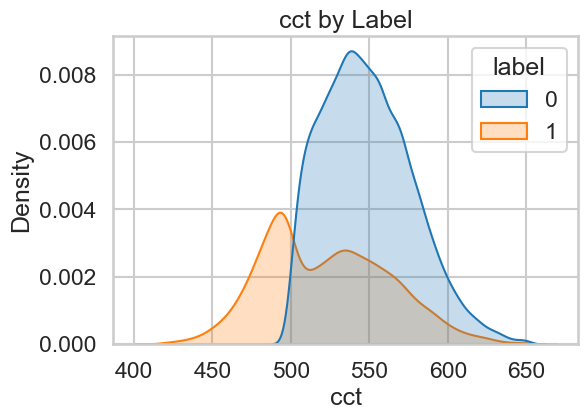

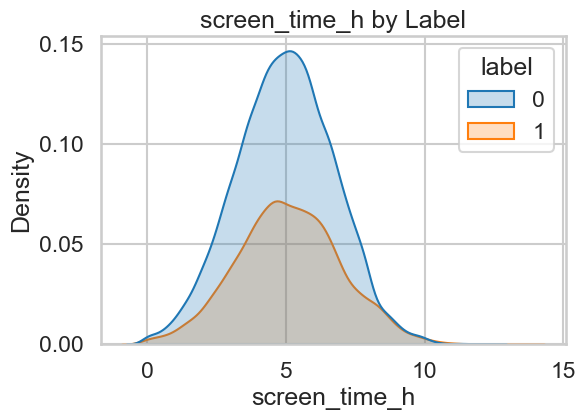

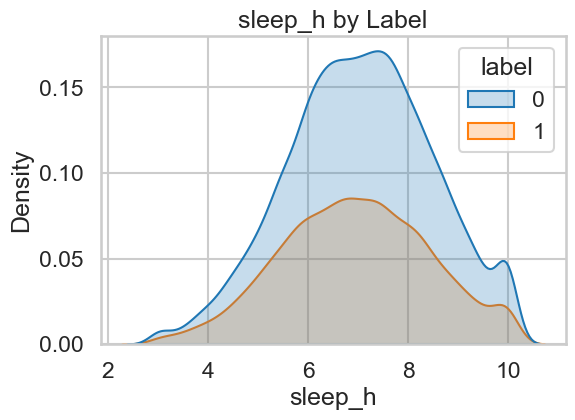

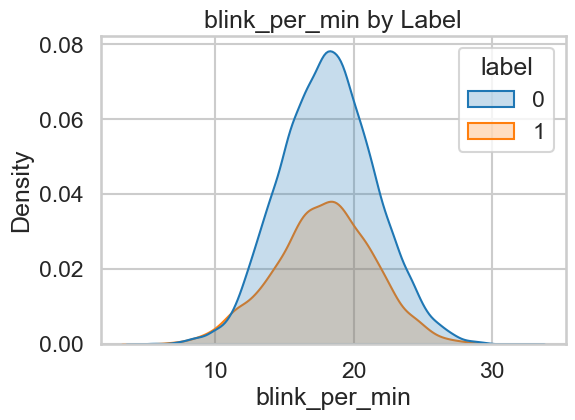

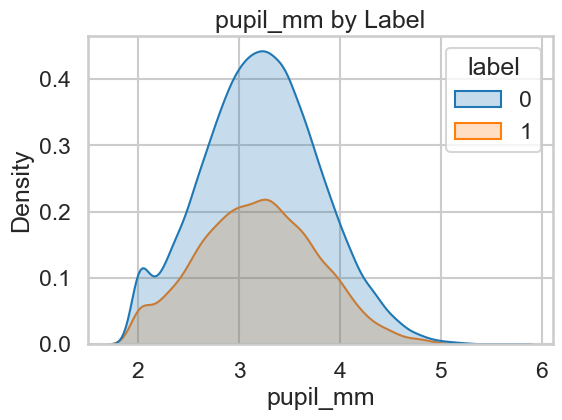

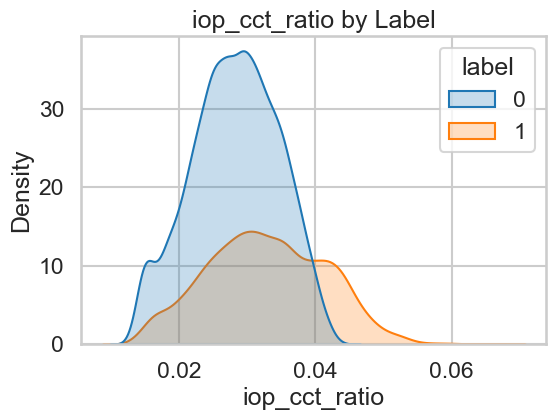

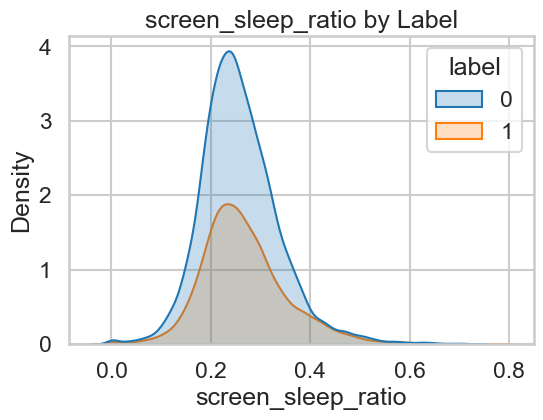

In [85]:
FEATURES = [c for c in data.columns if c not in ["id","label"]]
TARGET = "label"

# Class balance
fig, ax = plt.subplots(figsize=(5,4))
sns.countplot(x="label", hue="label", data=data, palette="Set2", legend=False, ax=ax)
ax.set_title("Class Distribution (0=Healthy, 1=Glaucoma Risk)")
plt.show()

# Correlation overview (no annotations for speed with 25k rows)
fig, ax = plt.subplots(figsize=(12,8))
corr = data[FEATURES+[TARGET]].corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", cbar=True, ax=ax)
ax.set_title("Feature Correlation Heatmap")
plt.show()

# A few key distributions by label
for feat in ["iop","cct","screen_time_h","sleep_h","blink_per_min","pupil_mm","iop_cct_ratio","screen_sleep_ratio"]:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(x=feat, data=data, hue="label", fill=True, ax=ax)
    ax.set_title(f"{feat} by Label")
    plt.show()


In [86]:
X = data[FEATURES]
y = data[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((20000, 14), (5000, 14), np.float64(0.3375), np.float64(0.3374))

In [87]:
# Pipelines with scaling where needed (trees don't need scaling)
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000)),
    "Random Forest": RandomForestClassifier(n_estimators=350, random_state=SEED, n_jobs=-1),
    "SVM (RBF)": make_pipeline(StandardScaler(), SVC(probability=True, kernel="rbf", random_state=SEED)),
    "MLP (Neural Net)": make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(128,64), max_iter=800, random_state=SEED)),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.06,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.5, random_state=SEED, n_jobs=-1,
        eval_metric="logloss"
    )
}

rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:,1]
    pred = (proba >= 0.50).astype(int)
    rows.append([
        name,
        accuracy_score(y_test, pred),
        precision_score(y_test, pred, zero_division=0),
        recall_score(y_test, pred, zero_division=0),
        f1_score(y_test, pred, zero_division=0),
        roc_auc_score(y_test, proba)
    ])

metrics_df = pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1","AUC"])
metrics_df = metrics_df.sort_values(["Accuracy","AUC"], ascending=False).reset_index(drop=True)
metrics_df.round(3)


,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost,0.872,0.983,0.632,0.770,0.826
1,Random Forest,0.871,0.975,0.634,0.768,0.821
2,SVM (RBF),0.826,0.837,0.602,0.700,0.807
3,MLP (Neural Net),0.798,0.727,0.642,0.682,0.798
4,Logistic Regression,0.760,0.714,0.484,0.577,0.749


In [88]:
# Use the trained XGBoost model from benchmarking
xgb_model = models["XGBoost"]

# Get probabilities & predictions
proba_test = xgb_model.predict_proba(X_test)[:,1]
y_pred = (proba_test >= 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, proba_test))


Classification Report:
               precision    recall  f1-score   support

           0      0.842     0.994     0.912      3313
           1      0.983     0.632     0.770      1687

    accuracy                          0.872      5000
   macro avg      0.912     0.813     0.841      5000
weighted avg      0.889     0.872     0.864      5000

Accuracy: 0.8722
AUC: 0.8260378230144009


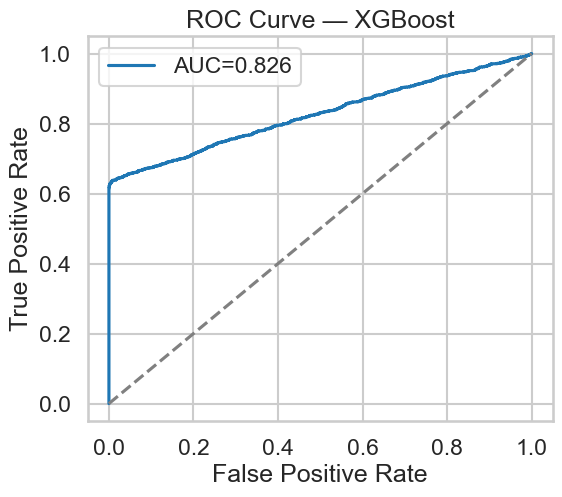

In [89]:
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, proba_test):.3f}")
plt.plot([0,1],[0,1],"--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost")
plt.legend()
plt.show()

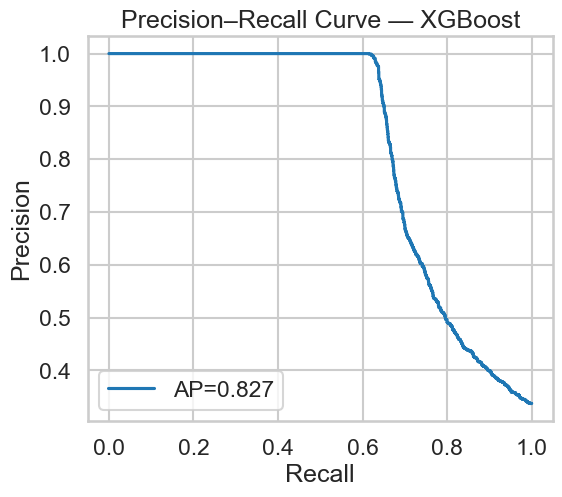

In [90]:
prec, rec, _ = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — XGBoost")
plt.legend()
plt.show()

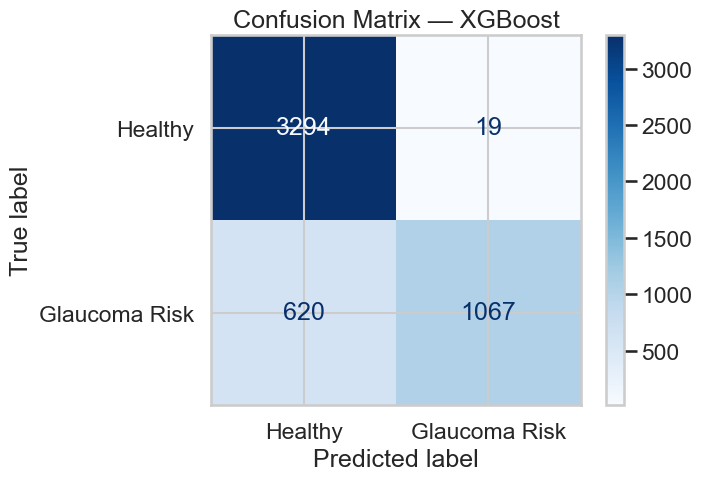

In [91]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=["Healthy","Glaucoma Risk"]).plot(cmap="Blues")
plt.title("Confusion Matrix — XGBoost")
plt.show()

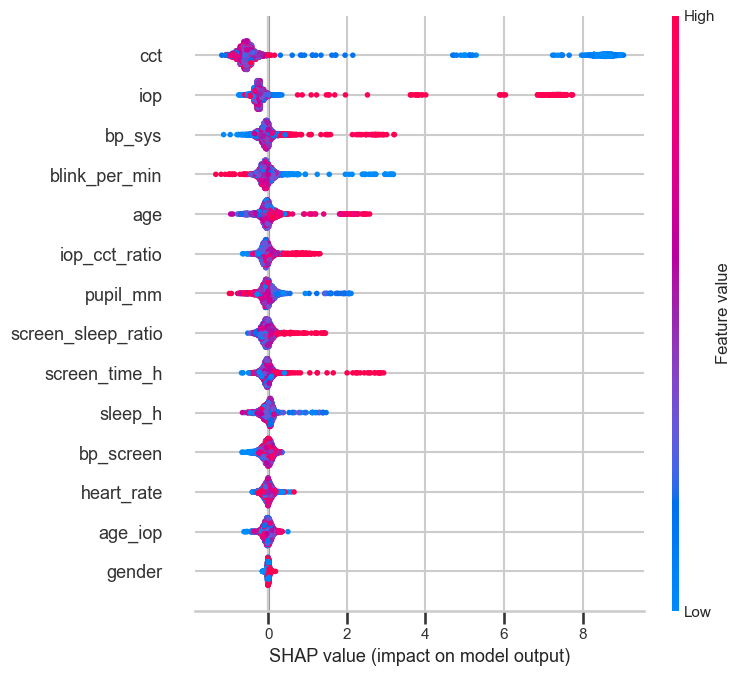

In [92]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)

# For speed, sample some rows
X_sample = X_test.sample(2000, random_state=SEED)
shap_values = explainer.shap_values(X_sample)

# Global importance
shap.summary_plot(shap_values, X_sample, show=True)

# Single patient explanation
i = 0  # change index to inspect different patient
shap.force_plot(explainer.expected_value, shap_values[i,:], X_sample.iloc[i,:])


In [93]:
os.makedirs("artifacts", exist_ok=True)
ts = time.strftime("%Y%m%d-%H%M%S")

joblib.dump(xgb_model, f"artifacts/xgb_model_{ts}.joblib")

with open(f"artifacts/meta_{ts}.json", "w") as f:
    json.dump({
        "features": FEATURES,
        "accuracy": float(accuracy_score(y_test,y_pred)),
        "auc": float(roc_auc_score(y_test, proba_test)),
        "precision": float(precision_score(y_test, y_pred)),
        "recall": float(recall_score(y_test, y_pred)),
        "f1": float(f1_score(y_test, y_pred)),
        "threshold": 0.5
    }, f, indent=2)

print("✅ Model + metadata saved in artifacts/")


✅ Model + metadata saved in artifacts/
